# A3

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import math
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def log1pexp(x):
    z = torch.stack([x, torch.zeros_like(x)], axis=-1)
    return torch.logsumexp(z, axis=-1)

In [3]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

## Binarized MNIST

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x>0.5).view(-1).to(torch.int8)),
])

ds = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
data_loader = DataLoader(ds, batch_size=256, shuffle=True, pin_memory=True)


## Model Implementation

In [5]:
Dz, Dh, Ddata = 2, 500, 28**2

In [6]:
def log_prior(z):
    """
    z: input tensor with shape (batch_size, Dz)
    """
    return torch.sum(-0.5 * (torch.log(torch.tensor(2 * math.pi, device=DEVICE)) + z ** 2), dim=-1)  # shape: (batch_size,)

def bernoulli_log_density(x, logit_means):
    """
    x: Input tensor with shape (batch_size, 784)
    logit_means: Input tensor with shape (batch_size, 784)
    """
    b = x * 2 - 1
    return torch.sum(-log1pexp(-b * logit_means), dim=-1)  # shape: (batch_size,)


decoder = nn.Sequential(nn.Linear(Dz, Dh),
                        nn.Tanh(),
                        nn.Linear(Dh, Ddata)).to(DEVICE)


def log_likelihood(x,z):
    return bernoulli_log_density(x, decoder(z))


def joint_log_density(x,z):
    return log_likelihood(x,z) + log_prior(z)  # shape: (batch_size, )

## Amortized Approximate Inference with Learned Variational Distribution

In [7]:
def log_q(z, mu, log_sigma):
    """
    z: tensor with shape (batch_size, Dz)
    mu: tensor with shape (batch_size, Dz)
    log_sigma: tensor with shape (batch_size, Dz)
    """
    
    return torch.sum(
        -0.5 * torch.log(torch.tensor(2 * math.pi, device=DEVICE)) - 
        log_sigma - 0.5 * ((z - mu) / torch.exp(log_sigma)) ** 2, dim=1)  # shape: (batch_size,)

In [8]:
encoder = nn.Sequential(nn.Linear(Ddata, Dh),
                        nn.Tanh(),
                        nn.Linear(Dh, 2 * Dz)).to(DEVICE)


def elbo(x):
    batch_size = x.size(0)
    enc_out = encoder(x)
    mu, log_sigma = enc_out[..., :Dz], enc_out[..., Dz:]
    z = torch.randn_like(log_sigma) * torch.exp(log_sigma) + mu
    joint_ll = joint_log_density(x, z)
    log_q_z = log_q(z, mu, log_sigma)
    elbo_estimate = torch.mean(joint_ll - log_q_z)  # scalar
    
    return elbo_estimate


def loss_fn(x):
    return -elbo(x)

## Optimize the model and amortized variational parameters

In [9]:
def train(enc, dec, data, loss_fn, n_epochs=10, print_every=100):
    optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=1e-4, )
        
    itrs = 0
    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}')
        for X_batch, y in data_loader:
            optimizer.zero_grad()
            loss = loss_fn(X_batch.to(DEVICE).float())
            
            if itrs % print_every == 0:
                print(f'\tIteration {itrs}, Loss {loss.item()}')

            loss.backward()
            optimizer.step()
            itrs += 1

In [10]:
train(encoder, decoder, data_loader, loss_fn)

Epoch 1
	Iteration 0, Loss 549.7537841796875
	Iteration 100, Loss 239.55226135253906
	Iteration 200, Loss 217.3089141845703
Epoch 2
	Iteration 300, Loss 206.4042510986328
	Iteration 400, Loss 205.44256591796875
Epoch 3
	Iteration 500, Loss 202.14120483398438
	Iteration 600, Loss 195.07321166992188
	Iteration 700, Loss 194.56509399414062
Epoch 4
	Iteration 800, Loss 192.37649536132812
	Iteration 900, Loss 189.75186157226562
Epoch 5
	Iteration 1000, Loss 189.11541748046875
	Iteration 1100, Loss 184.77554321289062
Epoch 6
	Iteration 1200, Loss 181.2893524169922
	Iteration 1300, Loss 182.61514282226562
	Iteration 1400, Loss 180.31704711914062
Epoch 7
	Iteration 1500, Loss 179.62680053710938
	Iteration 1600, Loss 179.3391571044922
Epoch 8
	Iteration 1700, Loss 184.02957153320312
	Iteration 1800, Loss 177.82423400878906
Epoch 9
	Iteration 1900, Loss 178.48048400878906
	Iteration 2000, Loss 178.63632202148438
	Iteration 2100, Loss 173.22193908691406
Epoch 10
	Iteration 2200, Loss 176.06509399

## Visualizing the Model Learned Representation

### 1. Latent Distribution of Batch

In [11]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmp = get_cmap(10)

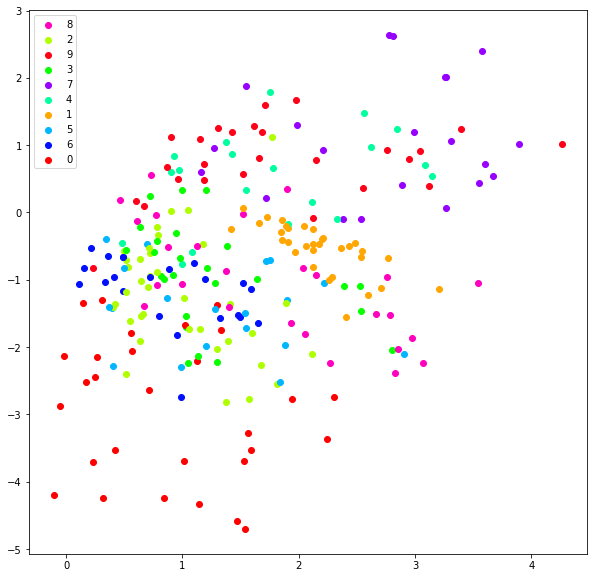

In [12]:
X_batch, y = next(iter(data_loader))
out = encoder(X_batch.to(DEVICE).float())
mu = out[..., :2].detach().cpu().numpy()

y = y.numpy()

plt.figure(figsize=(10, 10))

observed_labels = []
for y, (mu1, mu2) in zip(y, mu):
    if y in observed_labels:
        plt.scatter(mu1, mu2, color=cmp(y))
    else:
        plt.scatter(mu1, mu2, color=cmp(y), label=str(y))
        observed_labels.append(y)

plt.legend();

## 2. Visualizing Generative Model of Data

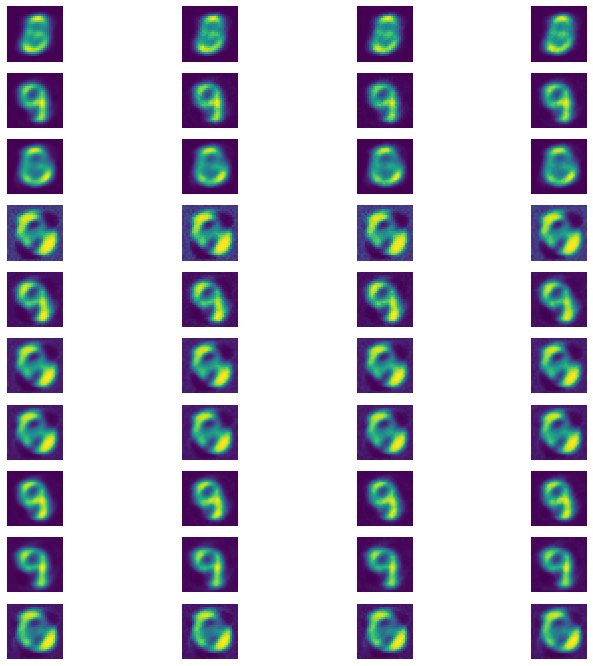

In [13]:
z = torch.randn(10, 2).to(DEVICE)
y = decoder(z)
mu = torch.sigmoid(y).detach().cpu().numpy()

fig, axes = plt.subplots(10, 4, figsize=(12, 12))

for i, m in enumerate(mu):
    axes[i, 0].imshow(m.reshape(28, 28))
    axes[i, 0].axis('off')
    for j in range(1, 4):
        sample = np.random.binomial(784, m)
        axes[i, j].imshow(sample.reshape(28, 28))
        axes[i, j].axis('off')

## 3. Visualizing Regenerative Model and Reconstruction

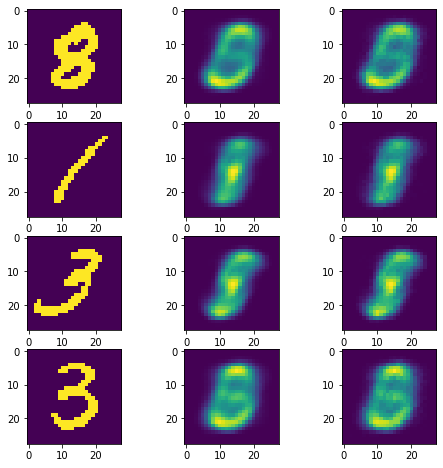

In [14]:
X_batch, y = next(iter(data_loader))
X_batch, y = X_batch[:4], y[:4]

out_enc = encoder(X_batch.to(DEVICE).float())
mu, log_sigma = out_enc[..., :2], out_enc[..., 2:]

samples = torch.randn_like(log_sigma) * torch.exp(log_sigma) + mu

y = decoder(samples)
mu = torch.sigmoid(y).detach().cpu().numpy()

fig, axes = plt.subplots(4, 3, figsize=(8, 8))

for i, m in enumerate(mu):
    sample = np.random.binomial(784, m)
    axes[i, 0].imshow(X_batch[i].numpy().reshape(28, 28))
    axes[i, 1].imshow(m.reshape(28, 28))
    axes[i, 2].imshow(sample.reshape(28, 28))

## 4. Latent Interpolation Along Lattice

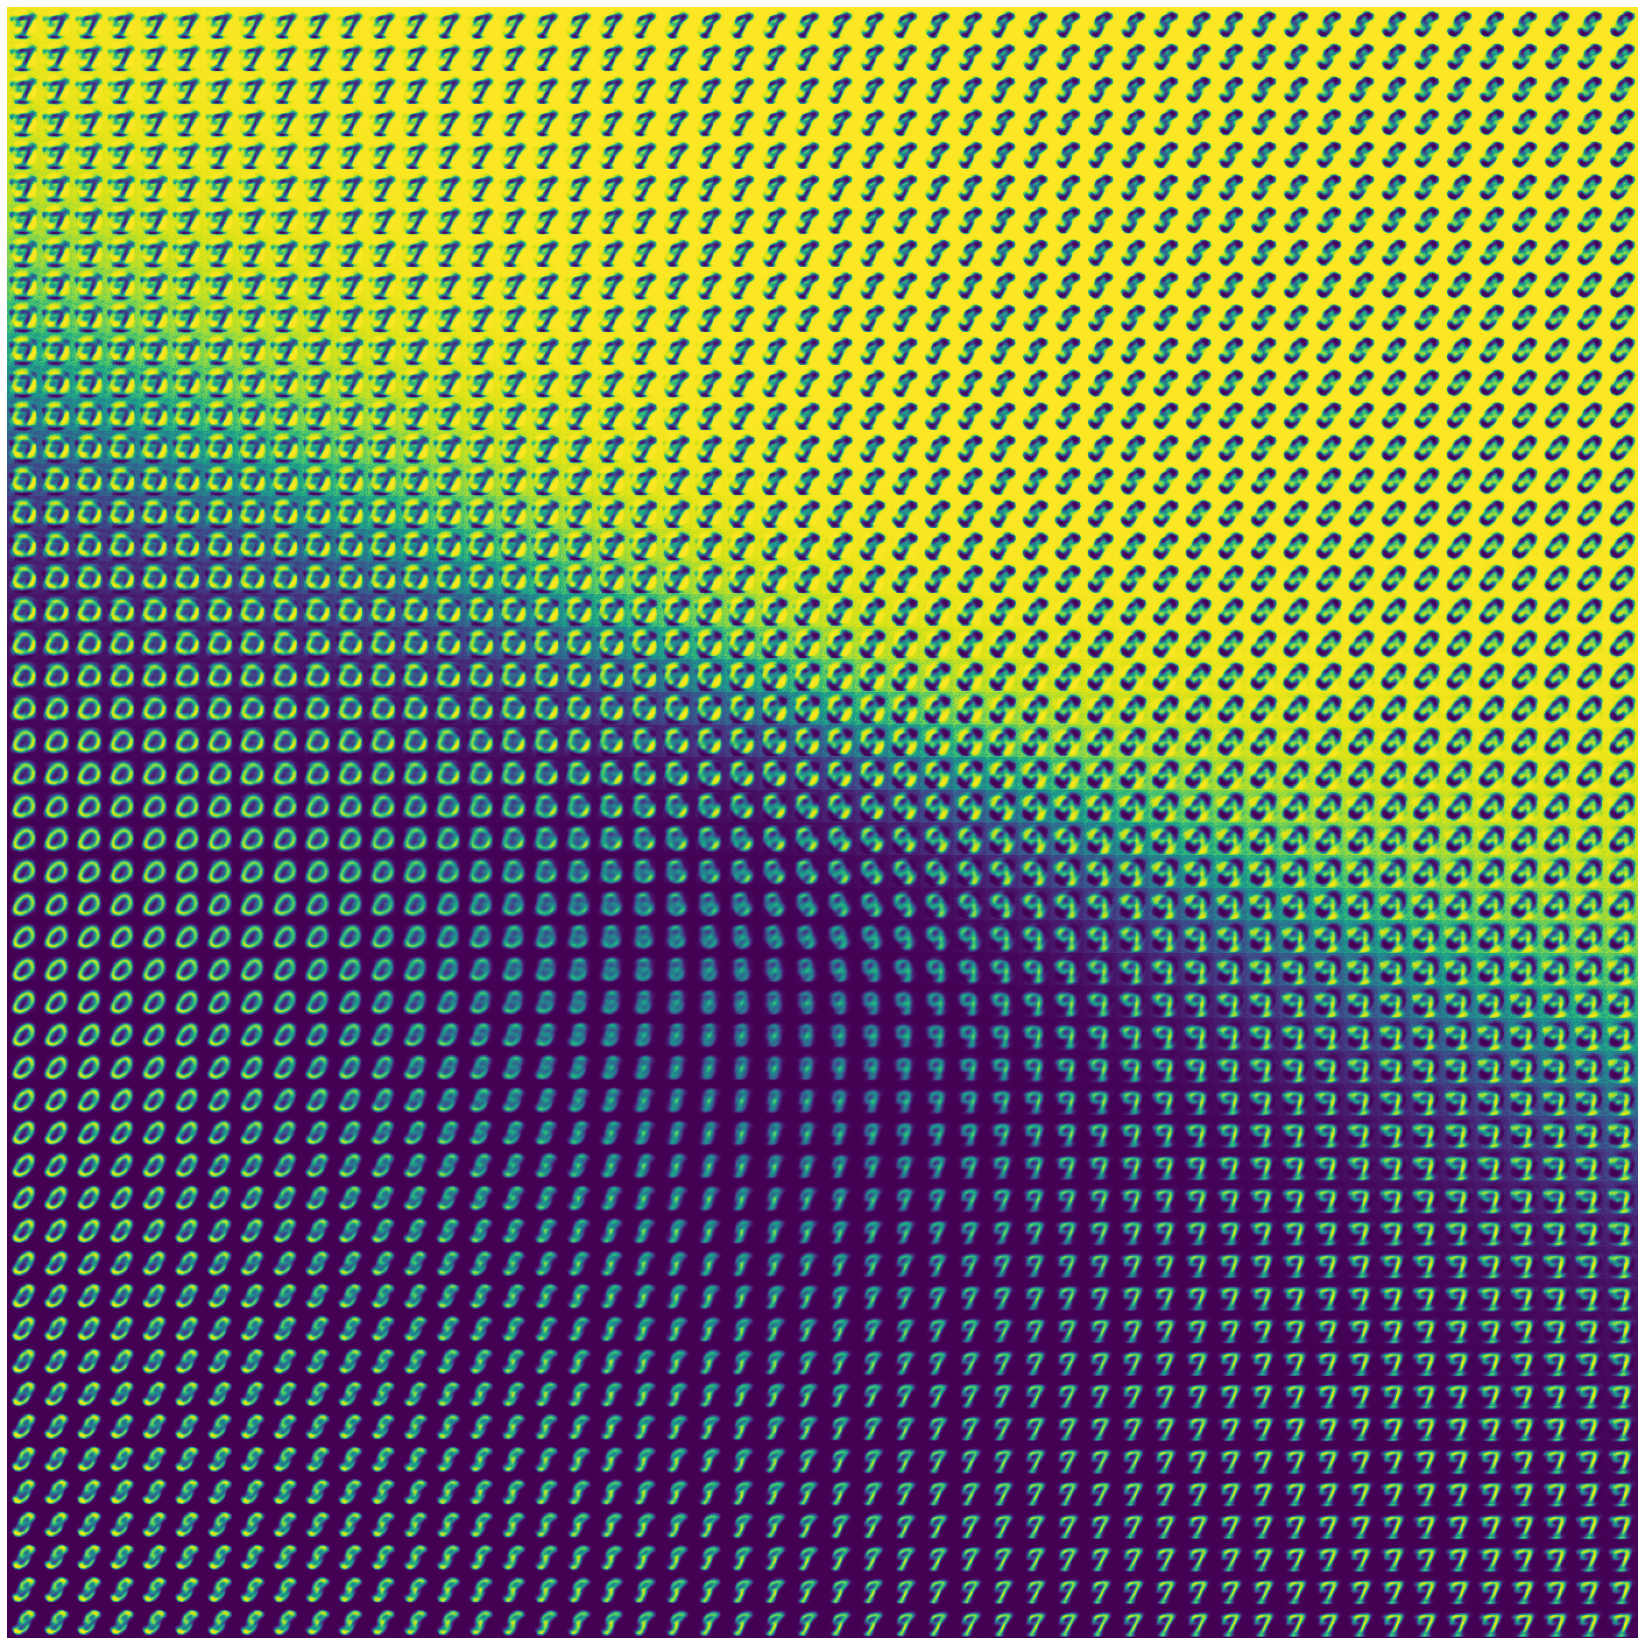

In [22]:
img = np.zeros([1400, 1400], dtype=np.float32)


xs = np.linspace(-5, 5, 50)
ys = np.linspace(-5, 5, 50)


for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        z = torch.tensor([x, y]).float().to(DEVICE)
        mu = torch.sigmoid(decoder(z)).detach().cpu().numpy()
        img[i*28:(i+1)*28, j*28:(j+1)*28] = mu.reshape(28, 28)

        
plt.figure(figsize=(30, 30))
plt.axis('off')
plt.imshow(img);